In [59]:
%%bash
git commit -a -m "checkpoint"

[master 28bd07d] checkpoint
 1 file changed, 29 insertions(+), 18 deletions(-)


In [60]:
1+1

2

In [1]:
%matplotlib inline

https://gist.github.com/santi-pdp/d0e9002afe74db04aa5bbff6d076e8fe

#  準備

* 正解がゼロとイチであるような100個のデータを作る
* ゼロの方よりイチのほうがすべての座標の平均が1.5大きい

In [2]:

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim


X1 = torch.randn(1000, 50)
X2 = torch.randn(1000, 50) + 1.5
X = torch.cat([X1, X2], dim=0)
Y1 = torch.zeros(1000, 1)
Y2 = torch.ones(1000, 1)
Y = torch.cat([Y1, Y2], dim=0)
print(X.size())
print(Y.size())

torch.Size([2000, 50])
torch.Size([2000, 1])


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [5]:
ax1 = fig.add_subplot(111)

In [9]:
ax1.scatter(X1[:,0] , X1[:,2] , color = "yellow")

In [7]:
ax1.scatter(X2[:,0] , X2[:,2], color = "red")

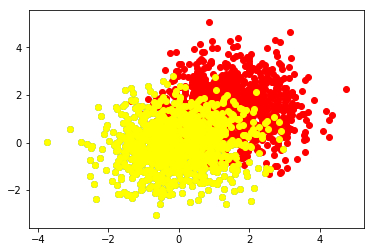

In [10]:
fig

In [8]:
X1.shape

torch.Size([1000, 50])

In [14]:
Y1.shape

torch.Size([1000, 1])

# ネットワークの定義

## 線形変換 (値が0,1間に入らないのでcriteriaを評価できずエラーになる)

In [15]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(50, 1)
        
    def forward(self, input_):
        y = self.fc1(input_)
        
        return y
    

##  線形変換＋sigmoid

In [118]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(50, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        y = self.out_act(a1)
        return y
    

## もともとのモデル

In [46]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(50, 50)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 100)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(100, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    

In [116]:
model = Net()

# optimizer

## 学習測度はここで指定する

learning rate次第で学習の成否が大きく異なってくる

In [119]:
opt = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))

# Binary cross entropy

ふたつの確率分布$p,q$があったときクロスエントロピーは

$$
H(p,q) =-{\rm E}_p[\log(q)]
$$

で定義される

説明変数のsample 
$$
x_0,x_1,\cdots , x_{N-1}
$$
に対して、正解が１であり、NNが確率$z$で１であると出力したとき、
正解の確率分布は


$$
 p(x) =
 \begin{cases}
        1 & x = 1\\
        0 & x = 0
 \end{cases}
$$
NNの導いた確率分布は
$$
 q(x) =
 \begin{cases}
        z & x = 1\\
        1-z & x = 0
 \end{cases}
$$
なのでクロスエントロピーは
$$
H(p,q) = -\log(z)
$$
であるが、
$$
H(q,p) = -z \log(1) - (1-z) \log(0)
$$
は計算できない

In [120]:
criterion = nn.BCELoss()

In [23]:
nn.BCELoss?

# training

## training modeに

In [109]:
model.train()

Net(
  (fc1): Linear(in_features=50, out_features=1, bias=True)
)

In [126]:
def yield_batch(X , Y , batch_size):
    for beg_i in range(0, X.size(0), batch_size):
        x_batch = X[beg_i:beg_i + batch_size, :]
        y_batch = Y[beg_i:beg_i + batch_size, :]
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)
        yield x_batch  ,y_batch
    

In [127]:
batch_size = 50

In [128]:
batch_iterator = yield_batch(X , Y  , batch_size)

In [129]:
x_batch , y_batch = next(batch_iterator)

## loop decomposed

### zero grad
毎回gradをクリアしないといけない

In [151]:
opt.zero_grad()

### Forward

In [152]:
y_hat = model(x_batch)

### Compute diff

In [153]:
loss = criterion(y_hat, y_batch)

### Compute gradients

In [ ]:
loss.backward()

### update weights

In [143]:
opt.step()        

### loss 

In [169]:
run_loss = float(loss.data.numpy())

In [170]:
print(run_loss)

0.7864750027656555


## original

def train_epoch(model, opt, criterion, batch_size=50):
    model.train()
    losses = []
    for beg_i in range(0, X.size(0), batch_size):
        x_batch = X[beg_i:beg_i + batch_size, :]
        y_batch = Y[beg_i:beg_i + batch_size, :]
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)


        opt.zero_grad()
        # (1) Forward
        y_hat = net(x_batch)
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()        
        losses.append(loss.data.numpy())
    return losses

In [112]:
e_losses = []
num_epochs = 200
for e in range(num_epochs):
    e_losses += train_epoch(net, opt, criterion)
plt.plot(e_losses)

RuntimeError: Assertion `x >= 0. && x <= 1.' failed. input value should be between 0~1, but got -0.507481 at /opt/conda/conda-bld/pytorch_1549624239588/work/aten/src/THNN/generic/BCECriterion.c:62

In [31]:
?Variable

In [49]:
batch_size = 50

In [56]:
losses = []
for beg_i in range(0, X.size(0), batch_size):
    x_batch = X[beg_i:beg_i + batch_size, :]
    y_batch = Y[beg_i:beg_i + batch_size, :]
    x_batch = Variable(x_batch)
    y_batch = Variable(y_batch)

    opt.zero_grad()
    # (1) Forward
    y_hat = net(x_batch)
    # (2) Compute diff
    loss = criterion(y_hat, y_batch)
    # (3) Compute gradients
    loss.backward()
    # (4) update weights
    opt.step()        
    losses.append(loss.data.numpy())

In [65]:
loss.backward?

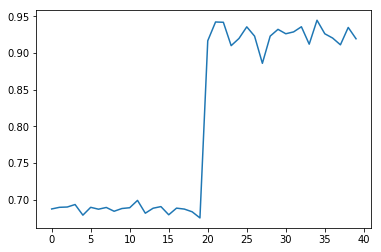

In [57]:
plt.plot(losses)

In [38]:
print(losses)

[array(0.5841407, dtype=float32), array(0.78728735, dtype=float32), array(0.6666336, dtype=float32), array(0.6594881, dtype=float32), array(0.6513859, dtype=float32), array(0.67031944, dtype=float32), array(0.7229451, dtype=float32), array(0.6275312, dtype=float32), array(0.6705452, dtype=float32), array(0.6870975, dtype=float32), array(0.6560946, dtype=float32), array(0.62905777, dtype=float32), array(0.6354866, dtype=float32), array(0.6645081, dtype=float32), array(0.6347938, dtype=float32), array(0.65994287, dtype=float32), array(0.7278479, dtype=float32), array(0.6654007, dtype=float32), array(0.65563226, dtype=float32), array(0.6332292, dtype=float32), array(0.6272269, dtype=float32), array(0.5968089, dtype=float32), array(0.66296023, dtype=float32), array(0.5867121, dtype=float32), array(0.581074, dtype=float32), array(0.515165, dtype=float32), array(0.4858858, dtype=float32), array(0.50516516, dtype=float32), array(0.44251278, dtype=float32), array(0.38719863, dtype=float32), ar

In [45]:
train_epoch(net, opt, criterion)

[array(0.08859807, dtype=float32),
 array(0.08276226, dtype=float32),
 array(0.09496175, dtype=float32),
 array(0.09042472, dtype=float32),
 array(0.104035, dtype=float32),
 array(0.08083595, dtype=float32),
 array(0.09815148, dtype=float32),
 array(0.08391771, dtype=float32),
 array(0.09721534, dtype=float32),
 array(0.10055164, dtype=float32),
 array(0.11461329, dtype=float32),
 array(0.09030148, dtype=float32),
 array(0.09727671, dtype=float32),
 array(0.0999218, dtype=float32),
 array(0.08108896, dtype=float32),
 array(0.09776808, dtype=float32),
 array(0.10559215, dtype=float32),
 array(0.09038907, dtype=float32),
 array(0.09328393, dtype=float32),
 array(0.10287318, dtype=float32),
 array(0.00499545, dtype=float32),
 array(0.00560064, dtype=float32),
 array(0.00553224, dtype=float32),
 array(0.00585382, dtype=float32),
 array(0.00543626, dtype=float32),
 array(0.00687941, dtype=float32),
 array(0.00621685, dtype=float32),
 array(0.00620025, dtype=float32),
 array(0.00524262, dtyp